Project - SQL & Data Wrangling

Import module / library

In [13]:
# import module / library and tools
import pandas as pd
import numpy as np
import sqlite3 as sq3
import matplotlib.pyplot as plt

from tabulate import tabulate



Connect database and check table name

In [14]:
# Connect to the SQLite database
conn = sq3.connect("olist.db")

# Create a cursor object
cur = conn.cursor()

# Get lists of table name
cur.execute("""
            SELECT name 
            FROM sqlite_master 
            WHERE type='table'
            """)

# Fetch all the table names and store them in a list
table_list = cur.fetchall()

# Print the list of table names
print("List of tables in the database:")
for index, table in enumerate(table_list):
    print(f"{index+1}. {table[0]}")

List of tables in the database:
1. olist_order_customer_dataset
2. olist_order_dataset
3. olist_order_reviews_dataset
4. olist_order_payments_dataset
5. olist_order_items_dataset
6. olist_products_dataset
7. olist_sellers_dataset
8. olist_geolocation_dataset
9. product_category_name_translation


Get Table

In [15]:
# Create data frame
data_customer = pd.read_sql_query("SELECT * FROM olist_order_customer_dataset", conn)
data_order = pd.read_sql_query("SELECT * FROM olist_order_dataset", conn)
data_review = pd.read_sql_query("SELECT * FROM olist_order_reviews_dataset", conn)
data_payment = pd.read_sql_query("SELECT * FROM olist_order_payments_dataset", conn)
data_order_item = pd.read_sql_query("SELECT * FROM olist_order_items_dataset", conn)
data_product = pd.read_sql_query("SELECT * FROM olist_products_dataset", conn)
data_seller = pd.read_sql_query("SELECT * FROM olist_sellers_dataset", conn)
data_loc = pd.read_sql_query("SELECT * FROM olist_geolocation_dataset", conn)
data_product_trans = pd.read_sql_query("SELECT * FROM  product_category_name_translation", conn)

Merging data

In [16]:
# Join table by key
merge_product = pd.merge(data_product, data_product_trans, on="product_category_name", how="left")
merge_order_item = pd.merge(data_order_item, data_seller, on="seller_id", how="left")
merge_order = pd.merge(data_order, data_customer, on="customer_id", how="left")

# Join table by key as final data
merge_1 = pd.merge(merge_order, merge_order_item, on="order_id", how="left")
merge_final = pd.merge(merge_1, merge_product, on="product_id", how="left")

# Create new column = total payment 
merge_final["payment"] = merge_final["price"] + merge_final["freight_value"]

# Drop unused column
drop_column = ["index_x_x", "order_approved_at", 
                "index_y_x", "product_name_lenght", "product_description_lenght",
                "product_photos_qty", "product_weight_g", "product_length_cm",
                "product_height_cm", "product_width_cm", "index_y", "customer_zip_code_prefix",
                "shipping_limit_date","index_y_y", "customer_unique_id", "seller_zip_code_prefix",
                "index_x", "customer_state", "seller_state", "index_x_y", "customer_id", "seller_id",
                "price", "freight_value", "product_category_name"]
merge_final = merge_final.drop(drop_column, axis=1)

# Show table
merge_final.head(3)

,order_id,order_status,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_city,order_item_id,product_id,seller_city,product_category_name_english,payment
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,sao paulo,1.0,87285b34884572647811a353c7ac498a,maua,housewares,38.71
1,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,barreiras,1.0,595fac2a385ac33a80bd5114aec74eb8,belo horizonte,perfumery,141.46
2,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,vianopolis,1.0,aa4383b373c6aca5d8797843e5594415,guariba,auto,179.12


Cleaning & Checking Data

In [17]:
# Data casting for datetime
merge_final["order_purchase_timestamp"] = pd.to_datetime(merge_final["order_purchase_timestamp"])
merge_final["order_delivered_carrier_date"] = pd.to_datetime(merge_final["order_delivered_carrier_date"])
merge_final["order_delivered_customer_date"] = pd.to_datetime(merge_final["order_delivered_customer_date"])
merge_final["order_estimated_delivery_date"] = pd.to_datetime(merge_final["order_estimated_delivery_date"])


merge_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113425 entries, 0 to 113424
Data columns (total 12 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       113425 non-null  object        
 1   order_status                   113425 non-null  object        
 2   order_purchase_timestamp       113425 non-null  datetime64[ns]
 3   order_delivered_carrier_date   111457 non-null  datetime64[ns]
 4   order_delivered_customer_date  110196 non-null  datetime64[ns]
 5   order_estimated_delivery_date  113425 non-null  datetime64[ns]
 6   customer_city                  113425 non-null  object        
 7   order_item_id                  112650 non-null  float64       
 8   product_id                     112650 non-null  object        
 9   seller_city                    112650 non-null  object        
 10  product_category_name_english  111023 non-null  object        
 11  

In [18]:
# Perform calculation values for checking data
total_count = merge_final.count() # Count rows of non null value
null_count = merge_final.isnull().sum() # Counts the number of null values in boolean and summed if null
percent_null = round((null_count / len(merge_final)) * 100, 2) # Calculates the percentage of null values / total number of rows
percent_null_df = pd.DataFrame(percent_null) # Create data frame from percent null for concat
duplicate_count = merge_final.duplicated().sum() # Counts the number of duplicate values in boolean and summed if duplicates

# Combines calculation results into one
result = pd.concat([total_count, null_count, percent_null_df, pd.Series(duplicate_count)], axis=1)

# Naming columns
result.columns = ["Value", "Null Value", "% Null Value", "Duplicate Value"]

# Show result
print(tabulate(result, headers="keys", tablefmt="psql"))

+-------------------------------+---------+--------------+----------------+-------------------+
|                               |   Value |   Null Value |   % Null Value |   Duplicate Value |
|-------------------------------+---------+--------------+----------------+-------------------|
| order_id                      |  113425 |            0 |           0    |               nan |
| order_status                  |  113425 |            0 |           0    |               nan |
| order_purchase_timestamp      |  113425 |            0 |           0    |               nan |
| order_delivered_carrier_date  |  111457 |         1968 |           1.74 |               nan |
| order_delivered_customer_date |  110196 |         3229 |           2.85 |               nan |
| order_estimated_delivery_date |  113425 |            0 |           0    |               nan |
| customer_city                 |  113425 |            0 |           0    |               nan |
| order_item_id                 |  11265

In [19]:
# Check the order status in the data
count_status = merge_final.groupby("order_status").size().reset_index(name="count")
print(count_status)

# Create new final data frame using only delivered order
delivered_data = merge_final.loc[merge_final["order_status"] == "delivered"]

  order_status   count
0     approved       3
1     canceled     706
2      created       5
3    delivered  110197
4     invoiced     361
5   processing     357
6      shipped    1186
7  unavailable     610


In [20]:
# Show the table checking using delivered data only

total_count = delivered_data.count() # Count rows of non null value 
null_count = delivered_data.isnull().sum() # Counts the number of null values in boolean and summed if null
percent_null = round((null_count / len(delivered_data)) * 100, 2) # Calculates the percentage of null values / total number of rows
percent_null_df = pd.DataFrame(percent_null) # Create data frame from percent null for concat
duplicate_count = delivered_data.duplicated().sum() # Counts the number of duplicate values in boolean and summed if duplicates

# Combines calculation results into one
result = pd.concat([total_count, null_count, percent_null_df, pd.Series(duplicate_count)], axis=1)

# Naming columns
result.columns = ["Value", "Null Value", "% Null Value", "Duplicate Value"]

# Show result
print(tabulate(result, headers="keys", tablefmt="psql"))


+-------------------------------+---------+--------------+----------------+-------------------+
|                               |   Value |   Null Value |   % Null Value |   Duplicate Value |
|-------------------------------+---------+--------------+----------------+-------------------|
| order_id                      |  110197 |            0 |           0    |               nan |
| order_status                  |  110197 |            0 |           0    |               nan |
| order_purchase_timestamp      |  110197 |            0 |           0    |               nan |
| order_delivered_carrier_date  |  110195 |            2 |           0    |               nan |
| order_delivered_customer_date |  110189 |            8 |           0.01 |               nan |
| order_estimated_delivery_date |  110197 |            0 |           0    |               nan |
| customer_city                 |  110197 |            0 |           0    |               nan |
| order_item_id                 |  11019

In [21]:
# Drop null values 
delivered_data = delivered_data.dropna(subset=["order_delivered_carrier_date"])
delivered_data = delivered_data.dropna(subset=["order_delivered_customer_date"])

# Checks the delivered date value which was previously null / nan
null_data = delivered_data[delivered_data["order_delivered_customer_date"].isnull()]
null_data


,order_id,order_status,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_city,order_item_id,product_id,seller_city,product_category_name_english,payment


In [22]:
# Calculate the time difference for seller to prepare the products untill it is received on logistic partner
time_diff_prep = delivered_data["order_delivered_carrier_date"] - delivered_data["order_purchase_timestamp"]

# Calculate the time difference between actual delivered date and the sent date
time_diff = delivered_data["order_delivered_customer_date"] - delivered_data["order_delivered_carrier_date"]

# Calculate the time difference between expected delviered date and the sent date
time_diff_sla = delivered_data["order_estimated_delivery_date"] - delivered_data["order_delivered_carrier_date"]


# Calculate the difference in days and hours
delivered_data["preparation_time_days"] = time_diff_prep.dt.days
delivered_data["delivery_time_days"] = time_diff.dt.days
delivered_data["SLA_time_days"] = time_diff_sla.dt.days

# Calculate difference days between expected delivery and actual delivery
delivered_data["SLA_diff_days"] = delivered_data["SLA_time_days"] - delivered_data["delivery_time_days"]

# Create categorization whether the delivery is over SLA (Service Level Agreement) or not
delivered_data["over_SLA"] = delivered_data.apply(lambda row: "Yes" if row["SLA_time_days"] - row["delivery_time_days"] < 0 else "No", axis=1)


# Show Result
delivered_data.head()


,order_id,order_status,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_city,order_item_id,product_id,seller_city,product_category_name_english,payment,preparation_time_days,delivery_time_days,SLA_time_days,SLA_diff_days,over_SLA
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,sao paulo,1.0,87285b34884572647811a353c7ac498a,maua,housewares,38.71,2,6,13,7,No
1,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,barreiras,1.0,595fac2a385ac33a80bd5114aec74eb8,belo horizonte,perfumery,141.46,1,12,17,5,No
2,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,vianopolis,1.0,aa4383b373c6aca5d8797843e5594415,guariba,auto,179.12,0,9,26,17,No
3,949d5b44dbf5de918fe9c16f97b45f8a,delivered,2017-11-18 19:28:06,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,sao goncalo do amarante,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,belo horizonte,pet_shop,72.20,3,9,22,13,No
4,ad21c59c0840e6cb83a9ceb5573f8159,delivered,2018-02-13 21:18:39,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,santo andre,1.0,65266b2da20d04dbe00c5c2d3bb7859e,mogi das cruzes,stationery,28.62,0,1,11,10,No


In [23]:
# Get unique values in column "product_category_name_english"
unique_product = delivered_data["product_category_name_english"].unique()
print(unique_product)

# Create a dictionary for replacing old values to new values
mapping = {
    "home_confort": "home_comfort",
    "home_comfort_2": "home_comfort",
    "home_appliances_2": "home_appliances"
}

# Replace the old value with the new value using the replace() method
delivered_data.loc[:, "product_category_name_english"] = delivered_data["product_category_name_english"].replace(mapping)

# Change the nan value to "Unknown"
delivered_data.loc[:,"product_category_name_english"] = delivered_data["product_category_name_english"].fillna("unknown")

# Checking the English product name value which was previously null / nan
null_data = delivered_data[delivered_data["product_category_name_english"].isnull()]
null_data


['housewares' 'perfumery' 'auto' 'pet_shop' 'stationery' 'furniture_decor'
 'office_furniture' 'garden_tools' 'computers_accessories'
 'bed_bath_table' 'toys' 'construction_tools_construction' 'telephony'
 'health_beauty' 'electronics' 'baby' 'cool_stuff' 'watches_gifts'
 'air_conditioning' 'sports_leisure' 'books_general_interest'
 'small_appliances' 'food' 'luggage_accessories' 'fashion_underwear_beach'
 nan 'fashion_bags_accessories' 'musical_instruments'
 'construction_tools_lights' 'books_technical' 'costruction_tools_garden'
 'home_appliances' 'market_place' 'agro_industry_and_commerce'
 'party_supplies' 'home_confort' 'cds_dvds_musicals'
 'industry_commerce_and_business' 'consoles_games' 'furniture_bedroom'
 'construction_tools_safety' 'fixed_telephony' 'drinks'
 'kitchen_dining_laundry_garden_furniture' 'fashion_shoes'
 'home_construction' 'audio' 'home_appliances_2' 'cine_photo'
 'furniture_living_room' 'art' 'fashion_male_clothing'
 'christmas_supplies' 'food_drink' 'tablets_

,order_id,order_status,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_city,order_item_id,product_id,seller_city,product_category_name_english,payment,preparation_time_days,delivery_time_days,SLA_time_days,SLA_diff_days,over_SLA


In [24]:
# Drop unused columns
drop_column1 = ["order_delivered_carrier_date", "order_delivered_customer_date", 
                "order_estimated_delivery_date", "order_status"]
delivered_data = delivered_data.drop(drop_column1, axis=1)

# Rename column name
delivered_data = delivered_data.rename(columns={
    "product_category_name_english": "product_category",
    "order_purchase_timestamp": "order_purchase",
    "seller_city": "origin_city",
    "customer_city": "destination_city"
})

""" 
Create a route column, based on :
origin city and destination city is in the same city, then "intracity"
origin city and destination city is not in the same city, then "intercity"
"""
delivered_data["route"] = np.where(delivered_data["origin_city"] == delivered_data["destination_city"], "intracity", "intercity")

# Show result
delivered_data.head(3)

,order_id,order_purchase,destination_city,order_item_id,product_id,origin_city,product_category,payment,preparation_time_days,delivery_time_days,SLA_time_days,SLA_diff_days,over_SLA,route
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,sao paulo,1.0,87285b34884572647811a353c7ac498a,maua,housewares,38.71,2,6,13,7,No,intercity
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,barreiras,1.0,595fac2a385ac33a80bd5114aec74eb8,belo horizonte,perfumery,141.46,1,12,17,5,No,intercity
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,vianopolis,1.0,aa4383b373c6aca5d8797843e5594415,guariba,auto,179.12,0,9,26,17,No,intercity


In [37]:
# Show the table checking using delivered data only after cleaning
print(tabulate(result, headers="keys", tablefmt="psql"))

+-----------------------+---------+--------------+----------------+-------------------+
|                       |   Value |   Null Value |   % Null Value |   Duplicate Value |
|-----------------------+---------+--------------+----------------+-------------------|
| order_id              |  110188 |            0 |              0 |               nan |
| order_purchase        |  110188 |            0 |              0 |               nan |
| destination_city      |  110188 |            0 |              0 |               nan |
| order_item_id         |  110188 |            0 |              0 |               nan |
| product_id            |  110188 |            0 |              0 |               nan |
| origin_city           |  110188 |            0 |              0 |               nan |
| product_category      |  110188 |            0 |              0 |               nan |
| payment               |  110188 |            0 |              0 |               nan |
| preparation_time_days |  11018

Visualization

Number of Delivered Orders by Month and Year

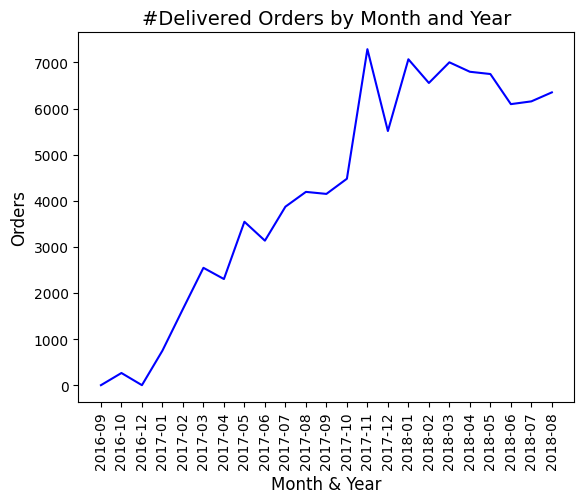

In [26]:
# Group by month and year and count order_id
order_count = delivered_data.groupby(delivered_data["order_purchase"].dt.to_period("M"))["order_id"].nunique()

# Create a line chart
plt.plot(order_count.index.astype(str), order_count.values, color="blue")

# Set the chart title and axis labels
plt.title("#Delivered Orders by Month and Year", fontsize=14)
plt.xlabel("Month & Year", fontsize=12)
plt.ylabel("Orders", fontsize=12)

# Rotate the x-axis labels
plt.xticks(rotation=90)

# Show the plot
plt.show()

Comparison delivered orders based on month

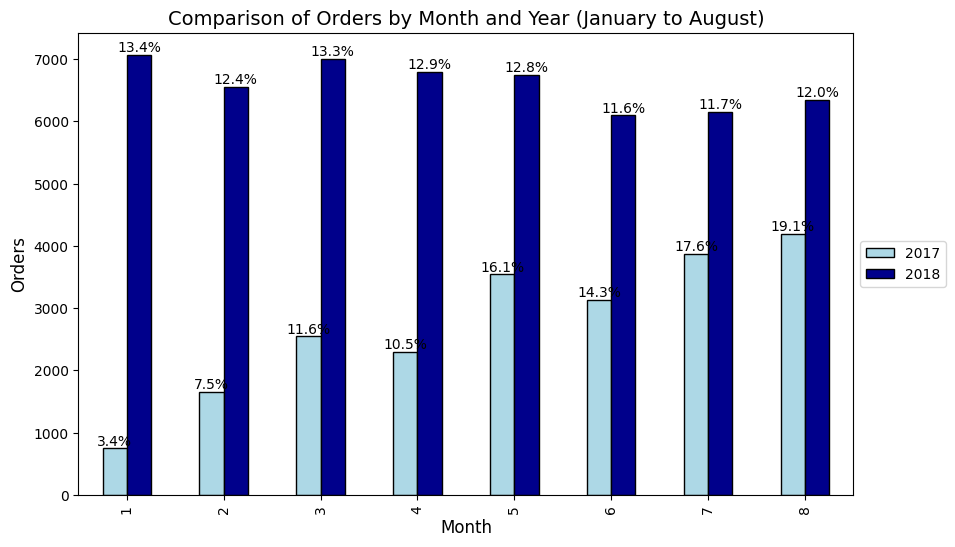

In [27]:
# Filter data for years 2017 and 2018 and months January to August
filtered_data = delivered_data[(delivered_data["order_purchase"].dt.year.isin([2017, 2018])) & (delivered_data["order_purchase"].dt.month.isin([1, 2, 3, 4, 5, 6, 7, 8]))]

# Group by year and month and count order_id
order_count = filtered_data.groupby([filtered_data["order_purchase"].dt.year, filtered_data["order_purchase"].dt.month])["order_id"].nunique()

# Reshape data into a pivot table
order_count = order_count.unstack(level=0)

# Plot the results as a bar chart
ax = order_count.plot(kind="bar", figsize=(10,6), color=["lightblue", "darkblue"], edgecolor="black")

# Set the chart title and axis labels
plt.title("Comparison of Orders by Month and Year (January to August)", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel('Orders', fontsize=12)

# Add percentage labels above each bar
for p in ax.containers:
    ax.bar_label(p, label_type='edge', fontsize=10, labels=[f'{x:.1%}' for x in p.datavalues/p.datavalues.sum()])

# Move the legend outside the chart
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

# Show the plot
plt.show()


Distribution by Route Type

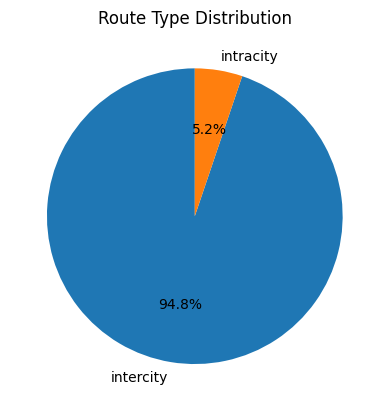

In [28]:
# Count the number of order_id
route_counts = delivered_data["route"].value_counts()

# Createpie chart
plt.pie(route_counts, labels=route_counts.index, autopct='%1.1f%%', startangle=90)

# Rename title
plt.title("Route Type Distribution")

# Show result
plt.show()

Number of Delivered Orders by Origin City (Top 5) and Route Type

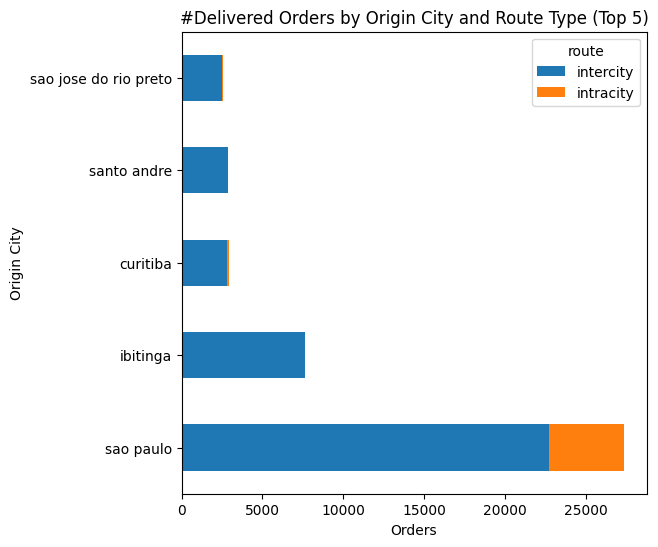

In [29]:
# Count the number of order_id in each city of origin
origin_city_counts = delivered_data["order_id"].groupby(delivered_data["origin_city"]).count()

# Get the top 5 origin city with the highest number of orders
top_origin_cities = origin_city_counts.nlargest(5)

# group data by origin_city and route
grouped_data = delivered_data.groupby(["origin_city", "route"]).count()["order_id"].unstack()

# select only top 5 origin cities by order count
grouped_data = grouped_data.loc[top_origin_cities.index]

# create stacked horizontal bar chart
fig, ax = plt.subplots(figsize=(6,6))
grouped_data.plot(kind="barh", stacked=True, ax=ax)

# set axis labels and title
ax.set_xlabel("Orders")
ax.set_ylabel("Origin City")
ax.set_title("#Delivered Orders by Origin City and Route Type (Top 5)")

plt.show()

Number of Delivered Orders by Destination City (Top 5) and Route Type

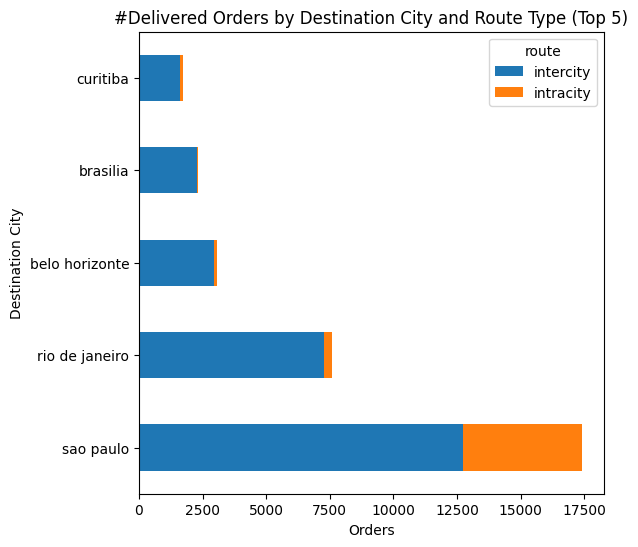

In [30]:
# Count the number of order_id in each city of origin
destination_city_counts = delivered_data["order_id"].groupby(delivered_data["destination_city"]).count()

# Get the top 5 destination city with the highest number of orders
top_destination_cities = destination_city_counts.nlargest(5)

# group data by destination_city and route
grouped_data = delivered_data.groupby(["destination_city", "route"]).count()["order_id"].unstack()

# select only top 5 destination cities by order count
grouped_data = grouped_data.loc[top_destination_cities.index]

# create stacked horizontal bar chart
fig, ax = plt.subplots(figsize=(6,6))
grouped_data.plot(kind="barh", stacked=True, ax=ax)

# set axis labels and title
ax.set_xlabel("Orders")
ax.set_ylabel("Destination City")
ax.set_title("#Delivered Orders by Destination City and Route Type (Top 5)")

plt.show()

Logistic Partner Delivery Performance

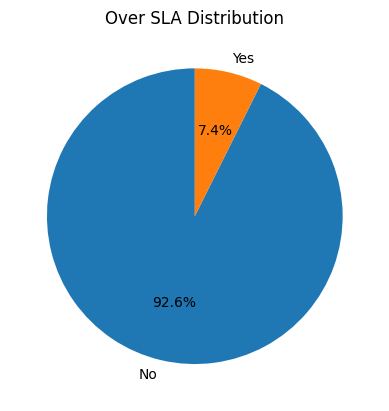

In [31]:
# Count the number of order_id
overSLA_counts = delivered_data["over_SLA"].value_counts()

# Createpie chart
plt.pie(overSLA_counts, labels=overSLA_counts.index, autopct='%1.1f%%', startangle=90)

# Rename title
plt.title("Over SLA Distribution")

# Show result
plt.show()

Over SLA Orders (Overall View)

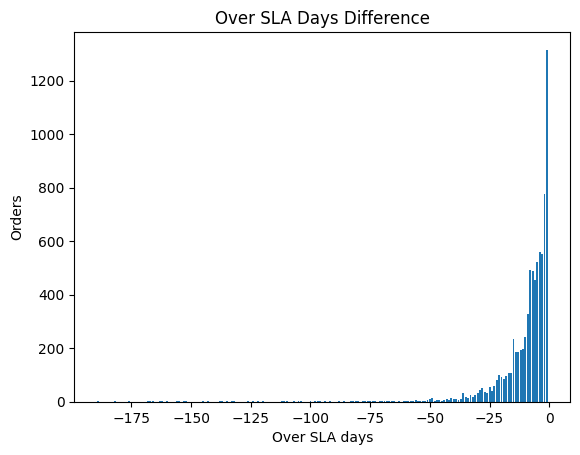

In [32]:
# Filter data based on orders that is over SLA
over_sla_data = delivered_data[delivered_data["over_SLA"] == "Yes"]

# Count over SLA orders
over_sla_counts = over_sla_data["SLA_diff_days"].value_counts().sort_index()

# Create horizontal bar chart
plt.bar(over_sla_counts.index, over_sla_counts.values, align="center")

# Rename title
plt.title("Over SLA Days Difference")

# Add x & y axis labels
plt.xlabel("Over SLA days")
plt.ylabel("Orders")

# Show result
plt.show()

Percentage Orders of Day Difference Over SLA

In [33]:
# Filter data for orders that are over SLA
over_sla_data = delivered_data[delivered_data["over_SLA"] == "Yes"]

# Create pivot table to calculate count and percentage of orders
pivot_table1 = over_sla_data.pivot_table(index="SLA_diff_days", values="order_id", aggfunc={"order_id": "count"})

# Calculate percentage of orders
total_overSLA1 = pivot_table1["order_id"].sum()
pivot_table1["Percentage"] = pivot_table1["order_id"] / total_overSLA1 * 100

# Sort pivot table by count of orders in descending order
pivot_table1.sort_values(by="order_id", ascending=False, inplace=True)

# Rename columns
pivot_table1.rename(columns={"order_id": "Over SLA Orders"}, inplace=True)

# Display pivot table
pivot_table1.head(25)

,Over SLA Orders,Percentage
SLA_diff_days,,
-1,1315,16.182624
-2,776,9.549594
-4,559,6.879153
-3,552,6.793010
-5,521,6.411519
-8,491,6.042333
-7,488,6.005415
-6,455,5.599311
-9,327,4.024120


Orders Based on SLA Delivery Route

In [34]:
# Create pivot table
pivot_table2 = pd.pivot_table(delivered_data, index=["origin_city", "destination_city", "route"],
                              values=["order_id"],
                              columns=["over_SLA"],
                              aggfunc={"order_id": "count"})

# Rename columns
pivot_table2.rename(columns={"Yes": "OverSLA", "No": "MeetSLA"}, inplace=True)

# Calculate total order
pivot_table2["Total Order"] = pivot_table2[("order_id", "OverSLA")] + pivot_table2[("order_id", "MeetSLA")]

# Calculate percentage of OverSLA
pivot_table2["% OverSLA"] = (pivot_table2[("order_id", "OverSLA")] / pivot_table2["Total Order"]) * 100

# Sort by OverSLA in descending order
pivot_table2.sort_values(by=("order_id", "OverSLA"), ascending=False, inplace=True)

# Show pivot table
pivot_table2.head(20)

order_id         Total Order   
over_SLA                                          MeetSLA OverSLA               
origin_city           destination_city route                                    
sao paulo             sao paulo        intracity   4392.0   282.0      4674.0  \
                      rio de janeiro   intercity   1419.0   177.0      1596.0   
ibitinga              rio de janeiro   intercity    482.0    99.0       581.0   
                      sao paulo        intercity   1242.0    80.0      1322.0   
sao paulo             salvador         intercity    283.0    62.0       345.0   
                      belo horizonte   intercity    633.0    46.0       679.0   
                      porto alegre     intercity    341.0    45.0       386.0   
                      campinas         intercity    367.0    41.0       408.0   
sao jose do rio preto rio de janeiro   intercity    165.0    40.0       205.0   
sao paulo             fortaleza        intercity    193.0    38.0       231.0   
ribeirao preto        sao paulo        intercity    329.0    31.0       360.0   
                      rio de janeiro   intercity    138.0    30.0       168.0   
sao paulo             brasilia         intercity    491.0    30.0       521.0   
santo andre           sao paulo        intercity    448.0    29.0       477.0   
itaquaquecetuba       rio de janeiro   intercity    164.0    28.0       192.0   
sao paulo             niteroi          intercity    159.0    26.0       185.0   
maringa               rio de janeiro   intercity    148.0    25.0       173.0   
guarulhos             sao paulo        intercity    344.0    24.0       368.0   
rio de janeiro        rio de janeiro   intracity    298.0    24.0       322.0   
sao paulo             guarulhos        intercity    319.0    23.0       342.0   

                                                  % OverSLA  
over_SLA                                                     
origin_city           destination_city route                 
sao paulo             sao paulo        intracity   6.033376  
                      rio de janeiro   intercity  11.090226  
ibitinga              rio de janeiro   intercity  17.039587  
                      sao paulo        intercity   6.051437  
sao paulo             salvador         intercity  17.971014  
                      belo horizonte   intercity   6.774669  
                      porto alegre     intercity  11.658031  
                      campinas         intercity  10.049020  
sao jose do rio preto rio de janeiro   intercity  19.512195  
sao paulo             fortaleza        intercity  16.450216  
ribeirao preto        sao paulo        intercity   8.611111  
                      rio de janeiro   intercity  17.857143  
sao paulo             brasilia         intercity   5.758157  
santo andre           sao paulo        intercity   6.079665  
itaquaquecetuba       rio de janeiro   intercity  14.583333  
sao paulo             niteroi          intercity  14.054054  
maringa               rio de janeiro   intercity  14.450867  
guarulhos             sao paulo        intercity   6.521739  
rio de janeiro        rio de janeiro   intracity   7.453416  
sao paulo             guarulhos        intercity   6.725146

In [35]:
# Filter data for orders that are over SLA based on intracity sao paulo
over_sla_data2 = delivered_data[(delivered_data["over_SLA"] == "Yes") & 
                               (delivered_data["origin_city"] == "sao paulo") &
                               (delivered_data["destination_city"] == "sao paulo")]

# Create pivot table to calculate count and percentage of orders
pivot_table3 = over_sla_data2.pivot_table(index=["origin_city", "destination_city","SLA_diff_days"], 
                                        values="order_id", 
                                        aggfunc={"order_id": "count"})

# Calculate percentage of orders
total_overSLA2 = pivot_table3["order_id"].sum()
pivot_table3["% Own"] = pivot_table3["order_id"] / total_overSLA2 * 100

# Calculate percentage of orders (all)
pivot_table3["% All"] = pivot_table3["order_id"] / total_overSLA1 * 100

# Sort pivot table by count of orders in descending order
pivot_table3.sort_values(by="order_id", ascending=False, inplace=True)

# Rename columns
pivot_table3.rename(columns={"order_id": "Over SLA Orders"}, inplace=True)

# Display pivot table
pivot_table3.head(25)

Over SLA Orders      % Own   
origin_city destination_city SLA_diff_days                               
sao paulo   sao paulo        -1                          79  28.014184  \
                             -2                          44  15.602837   
                             -4                          37  13.120567   
                             -3                          24   8.510638   
                             -5                          23   8.156028   
                             -7                          16   5.673759   
                             -6                          13   4.609929   
                             -10                          9   3.191489   
                             -8                           9   3.191489   
                             -16                          8   2.836879   
                             -11                          7   2.482270   
                             -9                           4   1.418440   
                             -12                          4   1.418440   
                             -26                          1   0.354610   
                             -14                          1   0.354610   
                             -19                          1   0.354610   
                             -22                          1   0.354610   
                             -82                          1   0.354610   

                                               % All  
origin_city destination_city SLA_diff_days            
sao paulo   sao paulo        -1             0.972188  
                             -2             0.541472  
                             -4             0.455329  
                             -3             0.295348  
                             -5             0.283042  
                             -7             0.196899  
                             -6             0.159980  
                             -10            0.110756  
                             -8             0.110756  
                             -16            0.098449  
                             -11            0.086143  
                             -9             0.049225  
                             -12            0.049225  
                             -26            0.012306  
                             -14            0.012306  
                             -19            0.012306  
                             -22            0.012306  
                             -82            0.012306